In [1]:
from chromatic_fitting import *
from chromatic import Rainbow, SimulatedRainbow
from pymc3 import Normal, Uniform, Model, HalfNormal, InverseGamma, Deterministic,  plot_trace, sample_prior_predictive, sample_posterior_predictive
from tqdm import tqdm
from pymc3_ext import eval_in_model, optimize, sample, ParameterGroup, estimate_inverse_gamma_parameters
from exoplanet import QuadLimbDark, ImpactParameter
plt.matplotlib.style.use('default')

Running on Python v3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:23:20) 
[Clang 12.0.1 ]
Running on numpy v1.22.3
Running on chromatic v0.2.2


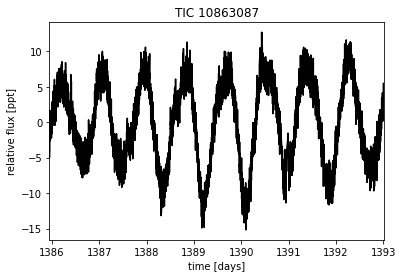

In [2]:
import lightkurve as lk

lcf = lk.search_lightcurve(
    "TIC 10863087", mission="TESS", author="SPOC"
).download_all(quality_bitmask="hardest", flux_column="pdcsap_flux")
lc = lcf.stitch().remove_nans().remove_outliers()
lc = lc[:5000]
_, mask = lc.flatten().remove_outliers(sigma=3.0, return_mask=True)
lc = lc[~mask]

x = np.ascontiguousarray(lc.time.value, dtype=np.float64)
y = np.ascontiguousarray(lc.flux, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err, dtype=np.float64)
mu = np.mean(y)
y = (y / mu - 1) * 1e3
yerr = yerr * 1e3 / mu

plt.plot(x, y, "k")
plt.xlim(x.min(), x.max())
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.title("TIC 10863087")

In [18]:
dict_to_rainbow = {'flux':np.array([y]*5), 'uncertainty':np.array([yerr]*5), 'time':x}


🌈 Warning: 
The time scale for this rainbow is '?',
and there are 4925 time centers and
0 time edges defined.

It's hard to imshow something with a time axis
that isn't linearly or logarithmically uniform, or doesn't
at least have its time edges defined. We're giving up
and just using the time index as the time axis.

If you want a real time axis, one solution would
be to bin your times to a more uniform grid with
`rainbow.bin(dt=...)` (for linear times).


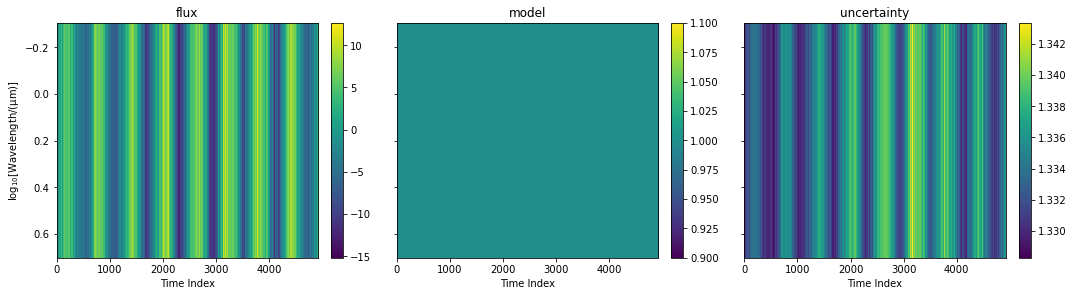

In [43]:
# s = Rainbow(dict_to_rainbow)
s = SimulatedRainbow(time=x*u.day, R=50)
s.fluxlike['flux'][:,:] = y
s.fluxlike['uncertainty'][:,:] = yerr
# s = s.bin(nwavelengths=int(s.nwave/5), dt=5 * u.hour)
s.imshow_quantities();

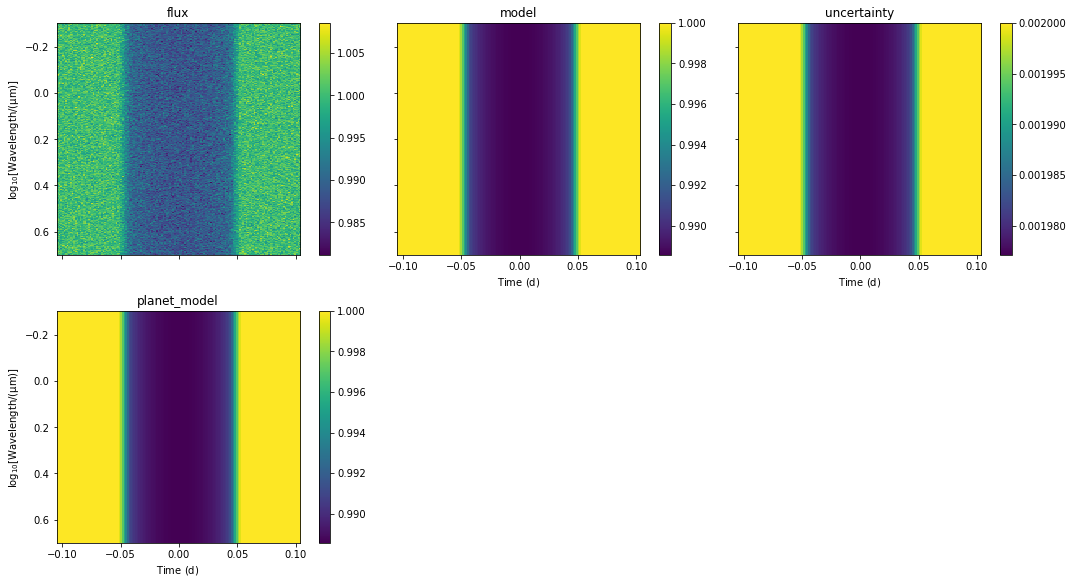

In [3]:
s = SimulatedRainbow().inject_transit().inject_noise(signal_to_noise=500) #inject_transit().
s.imshow_quantities();
s = s.bin(nwavelengths=int(s.nwave/5), dt=5 * u.minute)

In [44]:
# set up transit model:
gp = GP_SHO_Model()
gp.initialize_empty_model()

gp.setup_parameters(
#      period=Fitted(Uniform,testval=4.055259,lower=0.000009),
                sigma=Fitted(InverseGamma, **estimate_inverse_gamma_parameters(1.0, 5.0)),
                rho=Fitted(InverseGamma, **estimate_inverse_gamma_parameters(0.5, 2.0)),
                Q = Fitted(Normal, mu=1.0/np.sqrt(2.0)),
                log_jitter = Fitted(Normal,mu=np.log(np.mean(s.uncertainty)),sigma=2.0),
                mean = 1.0
                )
# A jitter term describing excess white noise
# A term to describe the non-periodic variability

In [45]:
gp.attach_data(s)
gp.setup_lightcurves()
gp.setup_likelihood()

In [46]:
opt = gp.optimize()
gp.sample(start=opt, tune=1000, draws=1000, cores=4, chains=4)
gp.summarize(round_to=7, fmt='wide')

optimizing logp for variables: [log_jitter, Q, rho, sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: -1093331.1982832241 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_jitter, Q, rho, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


                mean        sd    hdi_3%   hdi_97%  mcse_mean   mcse_sd  \
Q           0.753170  0.024748  0.707212  0.799229   0.000380  0.000270   
log_jitter -0.965100  0.014020 -0.991584 -0.939402   0.000222  0.000157   
sigma       5.688466  0.070047  5.554346  5.819489   0.001109  0.000785   
rho         0.724371  0.007460  0.710440  0.738168   0.000123  0.000087   

               ess_bulk     ess_tail     r_hat  
Q           4272.023650  3151.599985  1.002082  
log_jitter  3975.526975  2942.987661  1.002571  
sigma       3990.792149  2936.594286  1.000238  
rho         3646.278104  3198.199704  1.001993  


In [47]:
with gp.pymc3_model:
    ypred = eval_in_model(gp.gp.predict(y=gp.data.flux[0, :]))

In [48]:
ypred

array([-1.5138523 , -1.47854412, -1.44243667, ...,  2.92949825,
        2.97785441,  3.02527744])

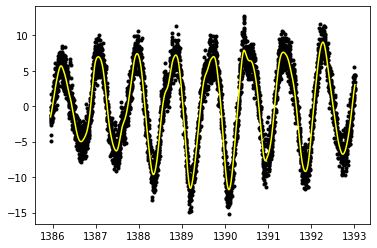

In [51]:
plt.plot(gp.data.time, gp.data.flux[0,:],'k.')
plt.plot(gp.data.time, ypred, color='yellow')